In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# scperturb package
sys.path.insert(1, '../../../package/src/')
from scperturb import *

%matplotlib inline

In [74]:
# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# # Stefan's utils
# sys.path.insert(1, utils_path)
# from scrnaseq_util_functions import *

In [2]:
h5_files = {}
spath = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'
for path, subdirs, files in os.walk(spath):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
print(len(h5_files))
# list(h5_files.keys())

41


In [3]:
dataset = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
et = pd.read_csv(f'../snakemake/tables/etest_{dataset}_tables.csv', index_col=0)

In [7]:
control = 'control'
groupby = 'perturbation'

res = {}
for group in tqdm(adata.obs[groupby].unique()):
    if group==control:
        continue
    sdata = adata[adata.obs[groupby].isin([control, group])].copy()
    sc.pp.highly_variable_genes(sdata, n_top_genes=2000, layer='counts', flavor='seurat_v3')
    sc.pp.pca(sdata)
    res[group] = edist(sdata, 'perturbation', 'X_pca', verbose=False).iloc[0,1]

100%|██████████| 84/84 [00:21<00:00,  3.92it/s]


In [8]:
ed_all = edist(adata)
ed_all_control = ed_all.loc[:, control]
ed_exclusive = pd.Series(res)

100%|██████████| 84/84 [00:18<00:00,  4.47it/s]


In [17]:
df = pd.concat([ed_all_control, ed_exclusive], axis=1)
df.columns = ['singlePCA', 'multiPCA']
df = df.fillna(0)
df = pd.concat([df, et], axis=1)

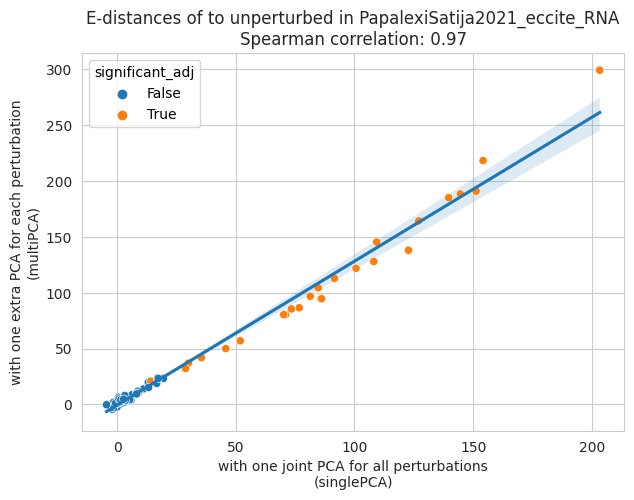

In [25]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[7,5], dpi=100)
sns.regplot(data=df, x='singlePCA', y='multiPCA', ax=ax, scatter_kws={'s': 0})
sns.scatterplot(data=df, x='singlePCA', y='multiPCA', hue='significant_adj', ax=ax)
from scipy.stats import spearmanr
r = spearmanr(df.singlePCA, df.multiPCA)[0]
ax.set_title(f'E-distances of to unperturbed in {dataset}\nSpearman correlation: {np.round(r,2)}')
ax.set_xlabel('with one joint PCA for all perturbations\n(singlePCA)')
ax.set_ylabel('with one extra PCA for each perturbation\n(multiPCA)')
pl.show()

In [26]:
dataset = 'NormanWeissman2019_filtered'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
et = pd.read_csv(f'../snakemake/tables/etest_{dataset}_tables.csv', index_col=0)

In [27]:
control = 'control'
groupby = 'perturbation'

res = {}
for group in tqdm(adata.obs[groupby].unique()):
    if group==control:
        continue
    sdata = adata[adata.obs[groupby].isin([control, group])].copy()
    sc.pp.highly_variable_genes(sdata, n_top_genes=2000, layer='counts', flavor='seurat_v3')
    sc.pp.pca(sdata)
    res[group] = edist(sdata, 'perturbation', 'X_pca', verbose=False).iloc[0,1]

100%|██████████| 237/237 [01:17<00:00,  3.04it/s]


In [28]:
ed_all = edist(adata)
ed_all_control = ed_all.loc[:, control]
ed_exclusive = pd.Series(res)

100%|██████████| 237/237 [01:33<00:00,  2.53it/s]


In [29]:
df = pd.concat([ed_all_control, ed_exclusive], axis=1)
df.columns = ['singlePCA', 'multiPCA']
df = df.fillna(0)
df = pd.concat([df, et], axis=1)

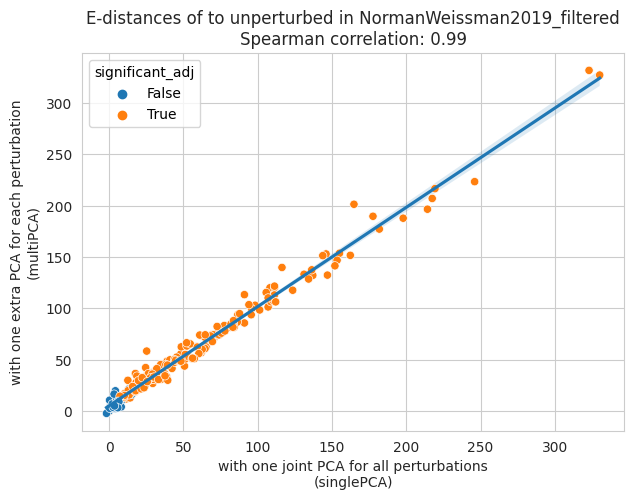

In [30]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[7,5], dpi=100)
sns.regplot(data=df, x='singlePCA', y='multiPCA', ax=ax, scatter_kws={'s': 0})
sns.scatterplot(data=df, x='singlePCA', y='multiPCA', hue='significant_adj', ax=ax)
from scipy.stats import spearmanr
r = spearmanr(df.singlePCA, df.multiPCA)[0]
ax.set_title(f'E-distances of to unperturbed in {dataset}\nSpearman correlation: {np.round(r,2)}')
ax.set_xlabel('with one joint PCA for all perturbations\n(singlePCA)')
ax.set_ylabel('with one extra PCA for each perturbation\n(multiPCA)')
pl.show()

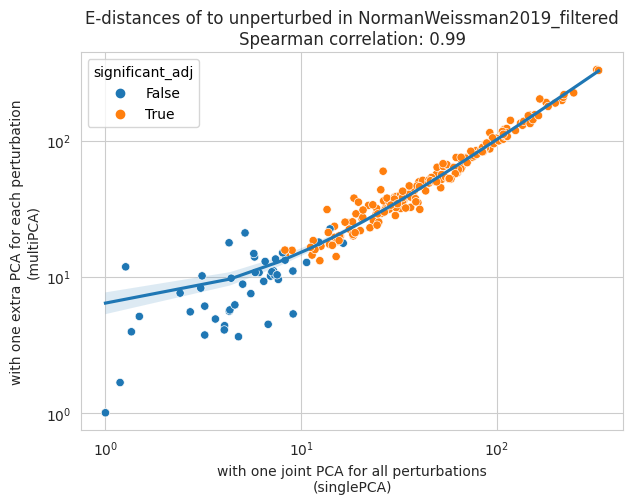

In [34]:
df = pd.concat([ed_all_control, ed_exclusive], axis=1)
df.columns = ['singlePCA', 'multiPCA']
df = df.fillna(0)
df = np.clip(df+1, 1, np.infty)
df = pd.concat([df, et], axis=1)

with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[7,5], dpi=100)
sns.regplot(data=df, x='singlePCA', y='multiPCA', ax=ax, scatter_kws={'s': 0})
sns.scatterplot(data=df, x=df.singlePCA, y=df.multiPCA, hue='significant_adj')
from scipy.stats import spearmanr
r = spearmanr(df.singlePCA, df.multiPCA)[0]
ax.set_title(f'E-distances of to unperturbed in {dataset}\nSpearman correlation: {np.round(r,2)}')
ax.set_xlabel('with one joint PCA for all perturbations\n(singlePCA)')
ax.set_ylabel('with one extra PCA for each perturbation\n(multiPCA)')
ax.set_yscale('log')
ax.set_xscale('log')
pl.show()